# Fan ID 00 - anomaly detection using spectrogram data

- The test will perform several runs that will compare the performances of different variants

1) Data :  Spectrogram with 1 frame, Spectrogram with 'bands'
2) With and without Gaussian
3) MIMII AE / More complex NN
4) Using MAE/MSE

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import tensorflow_probability as tfp
from tensorflow.keras import backend as K

## import functions
import sys
sys.path.append("..")
from src import GetParquet
from src import Train_test_sets_maker
from src import MinMaxNormalisation
from src import CoxboxTransform
from src import Visualize
from src import MIMII_AE
from src import AE_variant1

df_normal, df_abnormal = GetParquet.fun(1,1,0)
train_set, test_set, test_labels = Train_test_sets_maker.fun(df_normal,df_abnormal)
df_test_healthy = test_set[test_labels]
df_anomalous = test_set[~test_labels]
train_set = MinMaxNormalisation.fun(train_set)
test_set = MinMaxNormalisation.fun(test_set)

# save an instance as dataframe
df_train_set = train_set
df_test_set = test_set
# save an instance as tensorflow for training
tf_train_set = tf.cast(train_set, tf.float32)
tf_test_set = tf.cast(test_set, tf.float32)

Data acquired !
Train & test sets created !
Data normalized
Data normalized


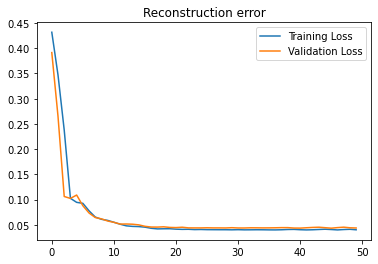

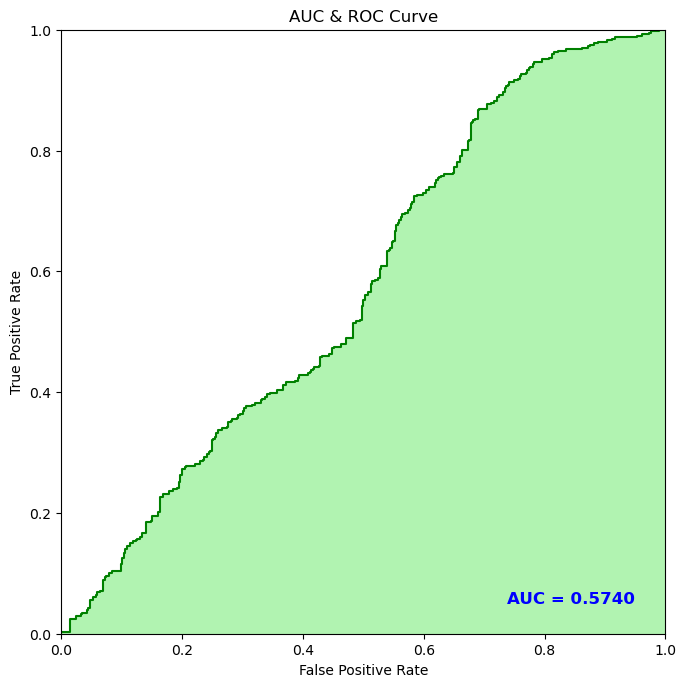

In [11]:
# Select AE architechture
InputSize = tf_train_set.shape[1]
autoencoder = MIMII_AE.fun(InputSize, 'mae')
# Train algorithm
history = autoencoder.fit(tf_train_set, tf_train_set, 
                          epochs=50, 
                          batch_size=512,
                          validation_data=(tf_test_set,tf_test_set),
                          verbose = 0,
                          shuffle=True)
# Visualize loss + AUC
Visualize.epoch_losses(history)
Visualize.AUC(test_labels,tf_test_set,autoencoder)

## Performance with Cox-Box transform

In [12]:
# All datapoints are shifter by 1, as the coxbox supports only STRICTLY positive numbers
CB_train_set = CoxboxTransform.fun(df_train_set+1)
CB_test_set = CoxboxTransform.fun(df_test_set+1)

# save an instance as tensorflow for training
CB_tf_train_set = tf.cast(CB_train_set, tf.float32)
CB_tf_test_set = tf.cast(CB_test_set, tf.float32)

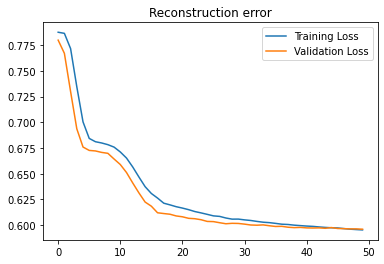

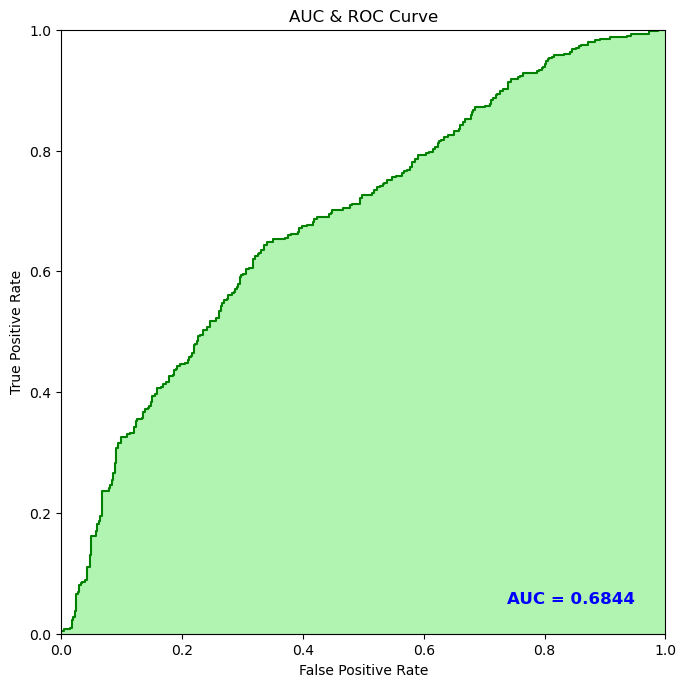

In [14]:
# Select AE architechture
InputSize = tf_train_set.shape[1]
autoencoder = MIMII_AE.fun(InputSize, 'mae')
# Train algorithm
history = autoencoder.fit(CB_tf_train_set, CB_tf_train_set, 
                          epochs=50, 
                          batch_size=512,
                          validation_data=(CB_tf_test_set,CB_tf_test_set),
                          verbose = 0,
                          shuffle=True)
# Visualize loss + AUC
Visualize.epoch_losses(history)
Visualize.AUC(test_labels,CB_tf_test_set,autoencoder)

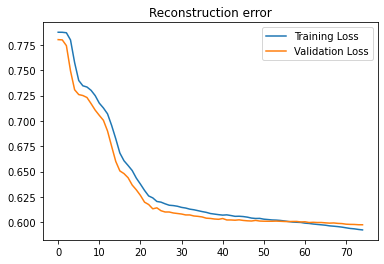

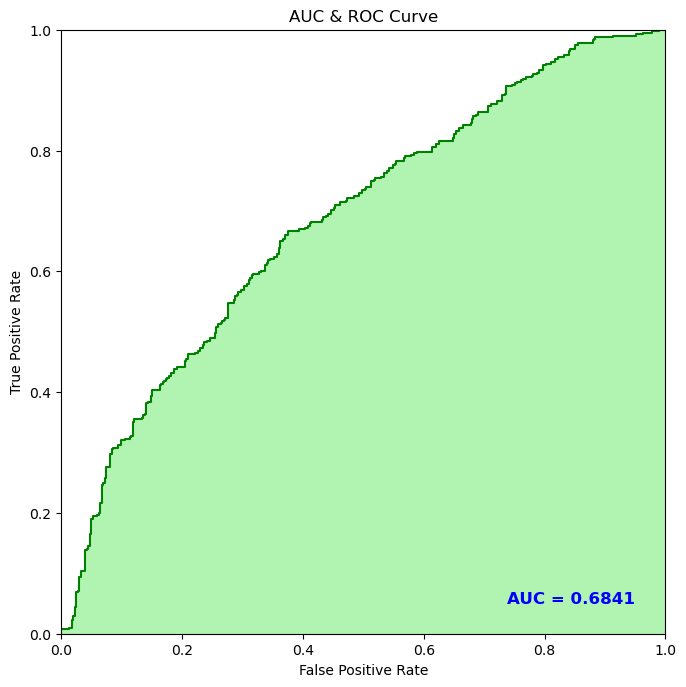

In [18]:
# Select AE architechture
InputSize = tf_train_set.shape[1]
LayerSup_size = 128
Latent_size = 8
autoencoder = AE_variant1.fun(InputSize, LayerSup_size, Latent_size, 'mae')
# Train algorithm
history = autoencoder.fit(CB_tf_train_set, CB_tf_train_set, 
                          epochs=75, 
                          batch_size=512,
                          validation_data=(CB_tf_test_set,CB_tf_test_set),
                          verbose = 0,
                          shuffle=True)
# Visualize loss + AUC
Visualize.epoch_losses(history)
Visualize.AUC(test_labels,CB_tf_test_set,autoencoder)

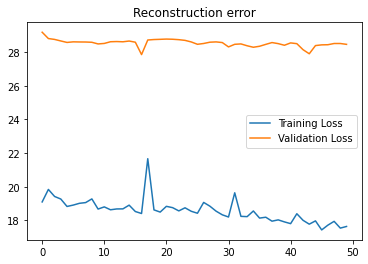

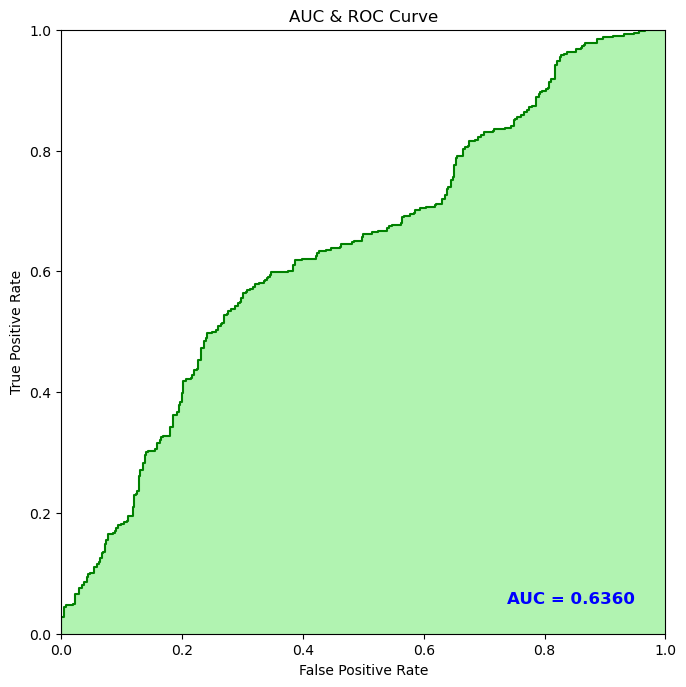

In [19]:
import numpy as np
def mahala_dist(y_pred, y_true):
    diff = y_pred - y_true # 1xInputSize
    cov = tfp.stats.covariance(tf.transpose(y_pred)) # Inputsize x Inputsize
    mull = K.dot(tf.linalg.inv(cov), diff)
    mull2 = K.dot(mull,tf.transpose(diff))
    dist = tf.sqrt(tf.math.abs(mull2))
    return dist

# Select AE architechture
InputSize = tf_train_set.shape[1]
autoencoder = MIMII_AE.fun(InputSize, mahala_dist)
# Train algorithm
history = autoencoder.fit(CB_tf_train_set, CB_tf_train_set, 
                          epochs=50, 
                          batch_size=512,
                          validation_data=(CB_tf_test_set,CB_tf_test_set),
                          verbose = 0,
                          shuffle=True)
# Visualize loss + AUC
Visualize.epoch_losses(history)
Visualize.AUC(test_labels,CB_tf_test_set,autoencoder)